# Introduction

In this notebook we are going to try few models to predict how many units of a product will be sold given a price

## 1 - Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import operator

from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category='FutureWarning')

import matplotlib.pyplot as plt
# import pylab

path = 'data/'

## 1.1 -  Data manipulation

In [2]:
df_sales = pd.read_csv(path + 'sales.csv')
df_sales['UNIT_VALUE'] = df_sales['REVENUE']/df_sales['QTY_ORDER']
df_sales['PROD_CAT'] = df_sales['PROD_ID'].astype('category').cat.codes
df_sales.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,UNIT_VALUE,PROD_CAT
0,P6,2015-08-02,1.0,1808.99,1808.99,5
1,P6,2015-08-17,1.0,1674.00,1674.00,5
2,P6,2015-08-17,1.0,1673.95,1673.95,5
3,P6,2015-08-11,1.0,1674.00,1674.00,5
4,P6,2015-08-17,1.0,1674.00,1674.00,5


In [3]:
df = df_sales.groupby(by=['PROD_CAT', 'UNIT_VALUE'])[['QTY_ORDER']].sum().reset_index()

### We are goint o split the data so we can standarlize the data using the mean and std of the train data.

In [4]:
test_data_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(df[['PROD_CAT','UNIT_VALUE']], df['QTY_ORDER'], test_size=test_data_size, random_state=0)

### Standardization

In [5]:
z_table = x_train.groupby(['PROD_CAT'], as_index=False).agg({'UNIT_VALUE':['mean','std']}).reset_index(drop=True)
z_table

PROD_CAT   UNIT_VALUE            
                   mean         std
0        0  1315.804375   88.772497
1        1   692.995899   77.214563
2        2  1294.087544   98.207684
3        3   493.516094   60.674927
4        4   845.165450  135.682866
5        5  1742.089266  170.709032
6        6   724.339744   85.586910
7        7   420.274844   51.487658
8        8   420.450110   56.087834

In [6]:
def stand(z, product, value):
    z_mean = z.loc[z['PROD_CAT'] == product]['UNIT_VALUE']['mean'].values[0]
    z_std =  z.loc[z['PROD_CAT'] == product]['UNIT_VALUE']['std'].values[0]
    
    if z_std == 0:
        return value
    
    return (value-z_mean)/z_std

In [7]:
x_train['VALUE_STAND'] = x_train.apply(lambda row: stand(z_table, row['PROD_CAT'], row['UNIT_VALUE']), axis=1)
x_test['VALUE_STAND'] = x_test.apply(lambda row: stand(z_table, row['PROD_CAT'], row['UNIT_VALUE']), axis=1)

In [8]:
x_train = x_train[['PROD_CAT', 'VALUE_STAND']]
x_test = x_test[['PROD_CAT', 'VALUE_STAND']]

## 2 - Training Models

In [9]:
def train_model(model_name, x_train, y_train, x_test, y_test):
    x_train_model = x_train.copy()
    x_test_model = x_test.copy()
    
    
    if model_name == 'linear':
        model_name = "Linear Regression"
        model = LinearRegression()
        
    elif model_name == 'poly_2':
        polyformer  = PolynomialFeatures(degree=2, include_bias=True)
        x_train_model = polyformer.fit_transform(x_train_model)
        x_test_model = polyformer.fit_transform(x_test_model)
        model = LinearRegression()

    elif model_name == 'poly_3':
        polyformer  = PolynomialFeatures(degree=3, include_bias=True)
        x_train_model = polyformer.fit_transform(x_train_model)
        x_test_model = polyformer.fit_transform(x_test_model)
        model = LinearRegression()
    
        
    model.fit(x_train_model , y_train)  
    y_train_pred = model.predict(x_train_model)
    y_pred = model.predict(x_test_model)

    score = model.score(x_test_model, y_test)

    mse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    print("Model: {}".format(model_name))
    print("Model Score: {}".format(score))
    print("\n")
    print("Performace on the training set")
    print("Mean squared error: {}".format(mse_train))
    print("RS score: {}".format(r2_train))
    print("\n")
    print("Performace on the test set")
    print("Mean squared error: {}".format(mse_test))
    print("RS score: {}".format(r2_test))
    
    
    x = x_train.loc[x_train["PROD_CAT"] == 1]["VALUE_STAND"].tolist()
    y = y_train[x_train.loc[x_train["PROD_CAT"] == 1].index].tolist()
    y_pred = y_train_pred[x_train.loc[x_train["PROD_CAT"] == 1].index].tolist()
    
    plt.scatter(x, y, color='red')
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)
    plt.plot(x, y_pred, color='blue')
    plt.title('Example on P1 in train set')
    plt.xlabel('Unit value (standardized)')
    plt.ylabel('Quantity sold')
    plt.show()
    
    
    
    return model

Model: Linear Regression
Model Score: -0.04925774777656455


Performace on the training set
Mean squared error: 1974.9997968039688
RS score: 0.0007957181796385271


Performace on the test set
Mean squared error: 459.7547876135844
RS score: -0.04925774777656455


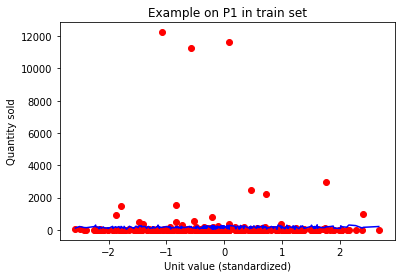

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
train_model("linear", x_train, y_train, x_test, y_test)

Model: poly_2
Model Score: -0.07828369381624367


Performace on the training set
Mean squared error: 1974.2441317361152
RS score: 0.0015601935210347584


Performace on the test set
Mean squared error: 466.07057708204354
RS score: -0.07828369381624367


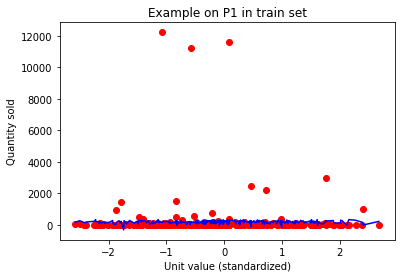

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
train_model("poly_2", x_train, y_train, x_test, y_test)

Model: poly_3
Model Score: -0.13937748996688293


Performace on the training set
Mean squared error: 1971.4593022216336
RS score: 0.004374965563334943


Performace on the test set
Mean squared error: 479.09207350628265
RS score: -0.13937748996688293


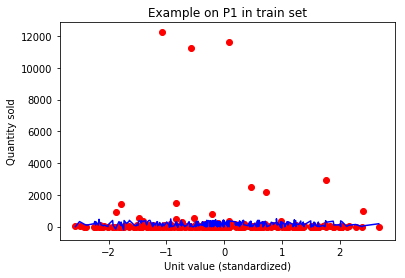

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
train_model("poly_3", x_train, y_train, x_test, y_test)

Model: Linear Regression
Model Score: -0.04925774777656455


Performace on the training set
Mean squared error: 1974.9997968039688
RS score: 0.0007957181796385271


Performace on the test set
Mean squared error: 459.7547876135844
RS score: -0.04925774777656455


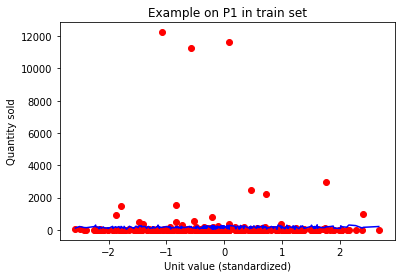

In [14]:
model_test = train_model("linear", x_train, y_train, x_test, y_test)

## 3 -  Saving model and testing result (in progress)

In [17]:
import pickle

# save the model
filename = 'finalized_model.sav'
pickle.dump(model_test, open(filename, 'wb'))

# load the model
model = pickle.load(open(filename, 'rb'))
result = model.score(x_test, y_test)
print(result)

-0.04925774777656455


In [18]:
teste = [[1, 100]]
teste[0][1] = stand(z_table, 1, 100)

#polyformer  = PolynomialFeatures(degree=3, include_bias=True)
#poly = polyformer.fit_transform(teste)

In [19]:
# Use the loaded pickled model to make predictions 
value = model_test.predict(teste) 
value

array([-101.94090317])

In [40]:
stand(z1, 1, 100)

-7.6628726742044275